# Рекомендация тарифов клиентам компании "Мегалайн"

«Мегалайн» — федеральный оператор сотовой связи. Предлагает клиентам  два тарифных плана: «Смарт» и «Ультра». 
«Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Оператор хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель исследования:** 

Построить модель для задачи классификации, которая выберет подходящий для пользователя тариф.

**Данные:**

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Предобработка данных не понадобится — мы подгружаем уже предобработанные данные.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Этапы-выполнения-проекта" data-toc-modified-id="Этапы-выполнения-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Этапы выполнения проекта</a></span></li><li><span><a href="#Открываем-и-изучаем-файл" data-toc-modified-id="Открываем-и-изучаем-файл-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Открываем и изучаем файл</a></span><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Разбиваем-данные-на-выборки" data-toc-modified-id="Разбиваем-данные-на-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разбиваем данные на выборки</a></span></li><li><span><a href="#Исследуем-модели" data-toc-modified-id="Исследуем-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследуем модели</a></span><ul class="toc-item"><li><span><a href="#Модель-решающего-дерева" data-toc-modified-id="Модель-решающего-дерева-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель решающего дерева</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li></ul></li><li><span><a href="#Проверяем-модели-на-тестовой-выборке" data-toc-modified-id="Проверяем-модели-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверяем модели на тестовой выборке</a></span></li><li><span><a href="#Проверяем-модели-на-адекватность" data-toc-modified-id="Проверяем-модели-на-адекватность-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверяем модели на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Этапы выполнения проекта
1. Открываем файл с данными и изучаем его. 
2. Делим исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследуем качество разных моделей, меняя гиперпараметры. 
4. Проверяем качество модели на тестовой выборке.
5. Проверяем модели на вменяемость.

## Открываем и изучаем файл

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

Откроем файл и ознакомимся с ним, прочитав первые строки.

In [2]:
path = '/datasets/users_behavior.csv'
try:
    df = pd.read_csv(path)
except Exception as err:
    try:
        df = pd.read_csv(path[10:])
    except Exception as err:
        print('Ошибка чтения файла:', repr(err))

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. В колонках представлены:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

В данном исследовании описание самих тарифов не имеет особой важности и предоставлена ниже ради чуть более полного понимания, так как нам предоставлены данные по клиентам, которые уже являются пользователями того или иного тарифа. Следовательно, мы имеем две категории клиентов со своими потребностями в количестве минут, сообщений и интернет-трафика, на основании которых будем строить нашу модель.

**Описание тарифов**

- **Тариф «Смарт»**

*Ежемесячная плата:* **550 рублей** *Включено* **500 минут разговора, 50 сообщений и 15 Гб интернет-трафика**

- **Тариф «Ультра»**

*Ежемесячная плата:* **1950 рублей** *Включено* **3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика**

*За использование минут, сообщений или интернет-трафика сверх тарифа взимается дополнительная плата*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице представлена информация о поведении 3214 пользователях.

Взглянем на распределение пользователей по тарифам.

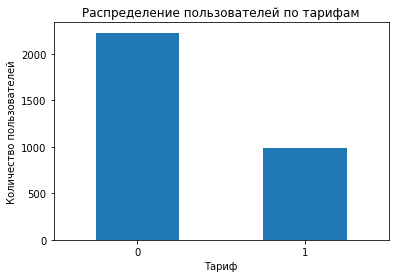

is_ultra
0    2229
1     985
Name: calls, dtype: int64

In [5]:
df.groupby('is_ultra').calls.count().plot(kind='bar', rot=0)
plt.xlabel('Тариф')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по тарифам')
plt.show()
df.groupby('is_ultra').calls.count()

Видим, что распределение пользователей не одинаковое, поэтому разумнее будет разбивать данные на стратифицированные выборки.

Данные о тарифе являются целевым признаком, а остальные стоит проверить на мультиколлинеарность.

Разделим данные на признаки и целевой признак.

In [6]:
# признаки
features = df.drop('is_ultra', axis=1)
# целевой признак
target = df['is_ultra']

Построим матрицу диаграмм рассеяния для визуальной проверки на корреляцию между признаками по шкале Чеддока.

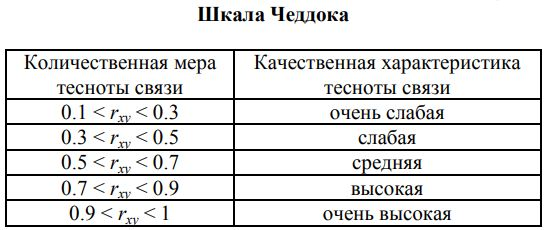


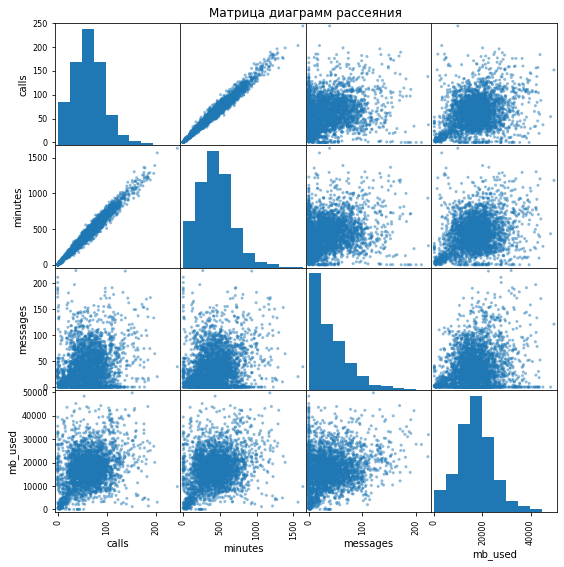

In [7]:
pd.plotting.scatter_matrix(features, figsize=(9, 9))
plt.title('Матрица диаграмм рассеяния', x=-1, y=4)
plt.show()

Видим, что между минутами и количеством звонков очень сильная корреляция.

In [8]:
features.corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


Корреляция между количеством звонков и потраченными минутами равна 0.98, что позволяет нам оставить только один из данных признаков. В тарифе есть ограничения по количеству потраченных минут, но не по количеству звонков, таким образом данные о количестве звонков можем исключить из таблицы.

In [9]:
features = features.drop('calls', axis=1)

## Разбиваем данные на выборки

Разобъем данные на тренировочную, валидационную и тестовую выборки в пропорциях 3:1:1. Для начала отделим 20% данных под тестовую выборку.

In [10]:
features_df, features_test, target_df, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=12345,
    shuffle=True,
    stratify=target
)

И теперь отделим от тренировочной выборки 25% под валидационную.

In [11]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_df,
    target_df,
    test_size=0.25,
    random_state=12345,
    shuffle=True,
    stratify=target_df
)

Посмотрим на размеры выборок.

In [12]:
features_train.shape, features_valid.shape, features_test.shape

((1928, 3), (643, 3), (643, 3))

Пропорция 3:1:1 соблюдена.

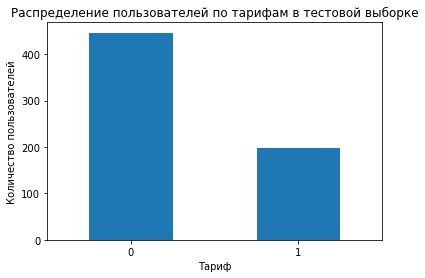

In [13]:
target_test.value_counts().plot(kind='bar', rot=0)
plt.xlabel('Тариф')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по тарифам в тестовой выборке')
plt.show()

Распределение пользователей по тарифам в тестовой выборке (и остальных) по пропорциям соответсвует исходной таблице.

## Исследуем модели

Далее исследуем модели решающего дерева, рандомного леса и логистической регрессии. Для оценки качества модели применим метрику качества `accuracy` - долю правильных ответов.

### Модель решающего дерева

Исследуем модели с разными глубинами дерева (от 1 до 10) и выберем из них лучшую.

In [14]:
model_tree = None
accuracy_tree = 0 
best_depth_tree = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(
        random_state=12345,
        max_depth=depth
    )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > accuracy_tree:
        model_tree = model
        accuracy_tree = result
        best_depth_tree = depth

In [15]:
print(f"Accuracy модели решающего дерева на валидационной выборке: {accuracy_tree:.4f} при глубине дерева {best_depth_tree}.")

Accuracy модели решающего дерева на валидационной выборке: 0.8118 при глубине дерева 10.


Выяснено, что наиболее подходящая глубина дерева для модели равна 10.

### Модель случайного леса

Исследуем модели с разными глубинами дерева (от 1 до 10) и разным количеством деревьев (от 1 до 50) и выберем из них лучшую.

In [16]:
model_forest = None
accuracy_forest = 0
best_depth_forest = 0
number_of_trees = 0
for estimator in range(1, 51):
    for depth in range(1, 11):
        model = RandomForestClassifier(
            random_state=12345,
            max_depth=depth,
            n_estimators=estimator
        )
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > accuracy_forest:
            model_forest = model
            accuracy_forest = result
            best_depth_forest = depth
            number_of_trees = estimator

In [17]:
print(f"Accuracy модели случайного леса на валидационной выборке: {accuracy_forest:.4f} при глубине дерева {best_depth_forest} \
и количестве деревьев {number_of_trees}.")

Accuracy модели случайного леса на валидационной выборке: 0.8289 при глубине дерева 6 и количестве деревьев 8.


Accuracy для модели случайного леса при глубине дерева 6 и количестве деревьев 8 выше, чем у модели решающего дерева.

### Модель логистической регрессии

In [18]:
model_regression = LogisticRegression(
    random_state=12345,
    solver='lbfgs'
)
model_regression.fit(features_train, target_train)
accuracy_regression = model_regression.score(features_valid, target_valid)

In [19]:
print(f"Accuracy модели логистической регрессии на валидационной выборке: {accuracy_regression:.4f}.")

Accuracy модели логистической регрессии на валидационной выборке: 0.7045.


Согласно accuracy моделей на валидационной выборке, по доле правильных ответов мы расположим их в следующем порядке (по убыванию):
1. Модель случайного леса
2. Модель решающего дерева
3. Модель логистической регрессии

## Проверяем модели на тестовой выборке

Мы подобрали параметры модели, обучая модель на тренировочной выборке и проверяя на валидационной. Теперь можем объединить эти две выборки и на них обучить модели с подобранными параметрами, и проверить долю правильных ответов на тестовой выборке.

У нас уже есть переменные, хранящие данные с тренировочной и тестовой выборками, это `features_df` и `target_df`. Обучим на них наши модели.

**Модель решающего дерева**

In [20]:
model_tree = DecisionTreeClassifier(
        random_state=12345,
        max_depth=10
    )
model_tree.fit(features_df, target_df)
predictions = model_tree.predict(features_test)
test_tree = accuracy_score(target_test, predictions)
print(f"Accuracy модели решающего дерева на тестовой выборке: {test_tree:.4f}.")

Accuracy модели решающего дерева на тестовой выборке: 0.7869.


- Доля правильных ответов при обучении модели решающего дерева на расширенной тренировочной выборке понизилась с 0.8118 на валидационной выборке до `0.7869` на тестовой выборке.

**Модель случайного леса**

In [21]:
model_forest = RandomForestClassifier(
            random_state=12345,
            max_depth=6,
            n_estimators=8
        )
model_forest.fit(features_df, target_df)
test_forest = model_forest.score(features_test, target_test)
print(f"Accuracy модели случайного леса на тестовой выборке: {test_forest:.4f}.")

Accuracy модели случайного леса на тестовой выборке: 0.8103.


- Доля правильных ответов при обучении модели случайного леса на расширенной тренировочной выборке понизилась с 0.8289 на валидационной выборке до `0.8103` на тестовой выборке.

**Модель логистической регрессии**

In [22]:
model_regression = LogisticRegression(
    random_state=12345,
    solver='lbfgs'
)
model_regression.fit(features_df, target_df)
test_regression = model_regression.score(features_test, target_test)
print(f"Accuracy модели логистической регрессии на тестовой выборке: {test_regression:.4f}.")

Accuracy модели логистической регрессии на тестовой выборке: 0.7092.


- Доля правильных ответов при обучении модели логистической регрессии на расширенной тренировочной выборке повысилась с 0.7045 на валидационной выборке до `0.7092` на тестовой выборке.
- Отметим, что при расширении обучающей выборки для моделей решающего дерева и случайного леса доля правильных ответов понизилась, а для модели логистической регрессии повысилась.

In [23]:
print(f"Accuracy моделей на тестовой выборке\
\nслучайного леса : {test_forest:.4f} \
\nрешающего дерева : {test_tree:.4f} \
\nлогистической регрессии: {test_regression:.4f}")

Accuracy моделей на тестовой выборке
случайного леса : 0.8103 
решающего дерева : 0.7869 
логистической регрессии: 0.7092


- Таким образом для системы, максимально точно рекомендующей пользователю подходящий тариф, есть основание предложить **модель рандомного леса при глубине дерева 6 и количестве деревьев 8**.

## Проверяем модели на адекватность

Чтобы проверить модели на адекватность, используем фиктивный классификатор `DummyClassifier`. 

Это тип классификатора, который не дает никакого представления о данных и классифицирует данные, используя только простые правила. Поведение классификатора полностью не зависит от обучающих данных, поскольку тенденции в обучающих данных полностью игнорируются. 

Он основан на философии, согласно которой любой аналитический подход к проблеме классификации должен быть лучше, чем подход случайного угадывания. Таким образом, accuracy данной модели должно быть ниже accuracy остальных.

In [24]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
  
test_scores = []
for s in strategies:
    if s =='constant':
        dummy = DummyClassifier(strategy = s, random_state = 0, constant = 1)
    else:
        dummy = DummyClassifier(strategy = s, random_state = 0)
    dummy.fit(features_train, target_train)
    score = dummy.score(features_test, target_test)
    test_scores.append(score)

Дополним списки значениями accuracy наших моделей.

In [25]:
strategies.extend(['random_forest', 'logistic_regression', 'decision_tree'])
test_scores.extend([test_forest, test_regression, test_tree])

Визуализируем accuracy для каждой модели.

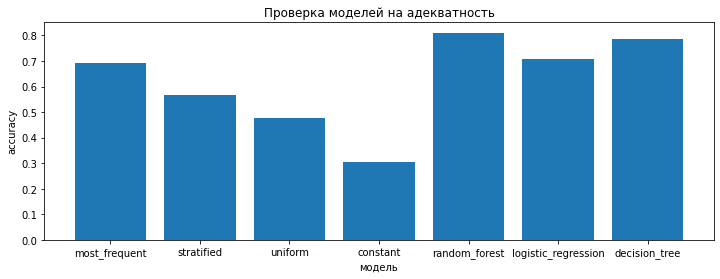

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.bar(strategies, test_scores)
plt.title('Проверка моделей на адекватность')
plt.xlabel('модель')
plt.ylabel('accuracy')
plt.show()

Таким образом, видим, что accuracy наших моделей выше моделей фиктивного классификатора.

## Вывод

В данном исследовании нам нужно было построить модель для задачи классификации, которая может выбрать подходящий для пользователя компании "Мегалайн" тариф: "Смарт" или "Ультра".

В нашем распоряжении были данные о поведении клиентов, которые уже перешли на эти тарифы.

В данном исследовании было использовано три разных модели:
1. Модель решающего дерева с разными глубинами дерева (от 1 до 10)
2. Модель рандомного леса с разными глубинами дерева (от 1 до 10) и разным количеством деревьев (от 1 до 50)
3. Модель логистической регрессии

Для оценки качества модели использовали метрику качества accuracy - долю правильных ответов.
- Для модели решающего дерева accuracy на валидационной выборке оказался лучшим при глубине дерева 10.
- Для модели случайного леса accuracy на валидационной выборке оказался лучшим при глубине дерева 6 и количестве деревьев 8.

**Проверка на валидационной выборке** показала, что модели по accuracy (указано в скобках) расположены в следующем порядке (по убыванию):
1. Модель случайного леса (0.8289)
2. Модель решающего дерева (0.8118)
3. Модель логистической регрессии (0.7045)

**Проверка на тестовой выборке** проходила при повторном обучении модели на расширенной выборке (обучающая + валидационная выборки) и показала измененные значения доли правильных ответов (по убыванию accuracy):
1. Модель случайного леса (0.8103)  
2. Модель решающего дерева (0.7869)
3. Модель логистической регрессии (0.7092)

Проверка моделей на адекватность подтвердила большую долю правильных ответов для использованных моделей чем у моделей фиктивного классификатора.

Таким образом, **моделью с наибольшей долей правильных ответов на тестовой выборке оказалась модель случайного леса с 8 деревьями глубиной 6**.